In [1]:
import urllib.request as urllib
import io
import zipfile
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import math

# download the data from the internet

In [2]:
url = "http://www-personal.umich.edu/~mejn/netdata/football.zip"

sock = urllib.urlopen(url)  # open an url
s = io.BytesIO(sock.read())  # read BytesIO file
sock.close()

zf = zipfile.ZipFile(s)  # ZipFile object
# txt = zf.read('football.txt').decode()  # read txt
gml = zf.read('football.gml').decode()  #  read gml data
# delete the first line
gml = gml.split('\n')[1:]
G = nx.parse_gml(gml)  # release gml数据
'''-----------------read data over-------------------'''
# print(txt)
# 打印每个队的度——比赛的数量
# for n, d in G.degree():
#     print('%s %d' % (n, d))

'-----------------read data over-------------------'

# visualize the graph

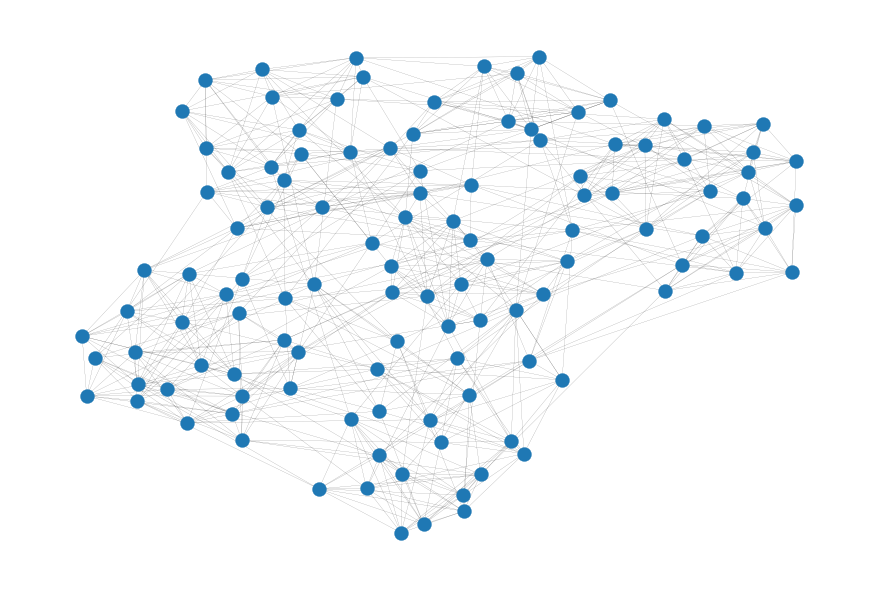

In [3]:
options = {
    # 'node_color': 'black',
    'node_size': 200,
    # 'line_color': 'grey',
    'linewidths': 0.2,
    'width': 0.1,
}
# Find key-values for the graph
pos = nx.spring_layout(G)
plt.figure(figsize=[12,8])
nx.draw(G, **options,cmap = plt.get_cmap('rainbow'), pos=pos, with_labels=False)

# print information of the graph

In [4]:
n = G.number_of_nodes()
m = G.number_of_edges()
print("Number of nodes :", str(n))
print("Number of edges :", str(m))
print("Number of connected components :" ,str(nx.number_connected_components(G)))


Number of nodes : 115
Number of edges : 613
Number of connected components : 1


对于无向图而言，115个节点理论上能产生$115*(115-1)/2=6555$条边

那么$D_1$=613，$D_2$=6555-613=5942

首先，先把$D_1$和$D_2$边数据集构造出来

##  构建$D1$,$D2$

In [5]:
D1=list(G.edges)

node_list=list(G.nodes)
D2=[]
for i in range(len(node_list)):
    for j in range(i+1,len(node_list)):
        source,target=node_list[i],node_list[j]
        D2.append((source,target))
# ok，D1,D2构建正常
len(set(D2)&set(D1))

613

#  分割D1为L_train,L_test,分割D2为L_ptrain,L_ptest

In [6]:
# split_rate = 0.7# 训练集百分比
# # 分割D1
# train_lens_1 = int(len(D1)*split_rate)
# L_train = D1[:train_lens_1]
# L_test = D1[train_lens_1:]
# print('split D1: ',len(L_train)+len(L_test) == len(D1))

# # 分割D2
# train_lens_2 = int(len(D2)*split_rate)
# L_ptrain = D2[:train_lens_2]
# L_ptest = D2[train_lens_2:]
# print('split D2: ',len(L_ptrain)+len(L_ptest) == len(D2))

# print('L_train: ',len(L_train))
# print('L_ptrain: ',len(L_ptrain))

##  从$D1$和$D2$中构建数据集$D list$

In [7]:
from random import sample
nums_Dk=10# 构建nums_Dk组数据集
D2_list=[]
# 没有设置随机种子，每次的抽样结果都是不同的
for i in range(nums_Dk):
    D2_sample=sample(D2,len(D1))
    D2_list.append(D2_sample)

# 提取特征

In [8]:
class FunctionSet:
    def __init__(self,G,Beta=1.84):
        '''
        β是超参数，论文的β为1.84和1.76
        '''
        self.G=G
        self.C=nx.average_clustering(G)
        self.function_list=[getattr(self, name) for name in dir(self) if name[0]!='_' and hasattr(getattr(self, name),'__call__')]
        self.function_name=[func.__name__ for func in self.function_list]
        self.Beta=Beta
    def _run_all(self,Dk,type=1):
        source=np.array([x[0] for x in Dk])[:,np.newaxis]
        target=np.array([x[1] for x in Dk])[:,np.newaxis]
        class_=np.array([type]*len(Dk))[:,np.newaxis]
        feature_data=np.array([[func(edge[0],edge[1]) for func in self.function_list] for edge in Dk])
        feature_data=np.hstack((np.hstack((np.hstack((source,target)),class_)),feature_data))
        feature_column=['source','target','class']+self.function_name
        df_Dk=pd.DataFrame(data=feature_data,columns=feature_column)
        return df_Dk
    # L(z) 计算
    def _L(self,z,common_neighbor):
        return sum(self.G.has_edge(z,w) for w in set(common_neighbor)-set([z]))
    # Jaccard 计算
    def Jaccard(self,u, v):
        union_size = len(set(self.G[u]) | set(self.G[v]))# 取并集
        if union_size == 0:
            return 0
        return len(list(nx.common_neighbors(self.G, u, v))) / union_size# 交集/并集
    # Common neighbor计算
    def CN(self,u,v):
        return len(list(nx.common_neighbors(self.G, u, v)))
    # adamic_adar计算
    def AA(self,u,v):
        return sum(1 / math.log(self.G.degree(w)) for w in nx.common_neighbors(self.G, u, v))
    # RA的计算
    def RA(self,u,v):
        return sum(1 / self.G.degree(w) for w in nx.common_neighbors(self.G, u, v))
    # ADP计算
    def ADP(self,u,v):
        C=nx.average_clustering(self.G)
        return sum(math.pow(self.G.degree(w),-1*self.Beta*C) for w in nx.common_neighbors(G, u, v))
    # CNDP计算
    def CNDP(self,u,v):
        common_neighbor=list(nx.common_neighbors(self.G,u,v))
        return sum(self._L(z,common_neighbor)*math.pow(self.G.degree(z),-1*self.Beta*self.C) for z in common_neighbor)
    # Salton 计算
    def Salton(self,u,v):
        return len(list(nx.common_neighbors(self.G, u, v))) /math.sqrt(self.G.degree(u)*self.G.degree(v))
    # Sorensen 计算
    def Sorensen(self,u,v):
        return 2*len(list(nx.common_neighbors(self.G, u, v))) /(self.G.degree(u)+self.G.degree(v))
    # HPI 计算
    def HPI(self,u,v):
        return len(list(nx.common_neighbors(self.G, u, v))) /min(self.G.degree(u),self.G.degree(v))
    # HDI 计算
    def HDI(self,u,v):
        return len(list(nx.common_neighbors(self.G, u, v))) /max(self.G.degree(u),self.G.degree(v))
    # LHN-I 计算
    def LHN_I(self,u,v):
        return len(list(nx.common_neighbors(self.G, u, v))) /(self.G.degree(u)*self.G.degree(v))
    # CAR计算
    def CAR(self,u,v):
        common_neighbor=list(nx.common_neighbors(self.G,u,v))
        return self.CN(u,v)*(1/2)*sum(self._L(z,common_neighbor) for z in common_neighbor)
    # CAA 计算
    def CAA(self,u,v):
        Z=list(nx.common_neighbors(self.G,u,v))
        return sum(self._L(z,Z)/math.log(self.G.degree(z)) for z in Z)
    # CRA 计算
    def CRA(self,u,v):
        Z=list(nx.common_neighbors(self.G,u,v))
        return sum(self._L(z,Z)/self.G.degree(z) for z in Z)
    # CCLP计算
    def CCLP(self,u,v):
        return sum(nx.clustering(self.G,z) for z in nx.common_neighbors(self.G,u,v))
    # NLC计算
    def NLC(self,u,v):
        def tmp_cal(x,y,z_):
            return (self.CN(x,z_)+self.CN(y,z_))/(self.G.degree(z_)-1)
        return sum(nx.clustering(self.G,z)*tmp_cal(u,v,z) for z in nx.common_neighbors(self.G,u,v))
    # MI计算
    # LNB-CN   
    # LNB-AA
    # LNB-RA    

## 先提取D1的

In [9]:
model=FunctionSet(G)
df_D1=model._run_all(D1,type=1)
df_D1

,source,target,class,AA,ADP,CAA,CAR,CCLP,CN,CNDP,CRA,HDI,HPI,Jaccard,LHN_I,NLC,RA,Salton,Sorensen
0,BrighamYoung,FloridaState,1,0.43429448190325176,0.18116843789290937,0.0,0.0,0.6444444444444445,1.0,0.0,0.0,0.08333333333333333,0.08333333333333333,0.043478260869565216,0.006944444444444444,0.6444444444444445,0.1,0.08333333333333333,0.08333333333333333
1,BrighamYoung,NewMexico,1,2.522115742461087,1.0269844435300226,12.610578712305434,90.0,2.7535353535353537,6.0,5.1349222176501135,2.78030303030303,0.5,0.5454545454545454,0.35294117647058826,0.045454545454545456,3.4965595347413525,0.556060606060606,0.5222329678670935,0.5217391304347826
2,BrighamYoung,SanDiegoState,1,2.522115742461087,1.0269844435300226,12.610578712305434,90.0,2.698989898989899,6.0,5.1349222176501135,2.78030303030303,0.5,0.5454545454545454,0.35294117647058826,0.045454545454545456,3.5303642485460665,0.556060606060606,0.5222329678670935,0.5217391304347826
3,BrighamYoung,Wyoming,1,2.522115742461087,1.0269844435300226,12.610578712305434,90.0,2.7535353535353537,6.0,5.1349222176501135,2.78030303030303,0.5,0.5454545454545454,0.35294117647058826,0.045454545454545456,3.5416039179675534,0.556060606060606,0.5222329678670935,0.5217391304347826
4,BrighamYoung,Utah,1,2.977235355774506,1.2228828128392037,12.610578712305434,105.0,3.0505050505050506,7.0,5.1349222176501135,2.78030303030303,0.5833333333333334,0.6363636363636364,0.4375,0.05303030303030303,3.4908019589837767,0.6671717171717172,0.6092717958449424,0.6086956521739131
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608,Clemson,Maryland,1,2.9391481338853334,1.195784498545069,17.634888803312002,147.0,3.823232323232323,7.0,7.174706991270416,3.881818181818182,0.6363636363636364,0.7,0.5,0.06363636363636363,5.50055300479543,0.6469696969696971,0.6674238124719146,0.6666666666666666
609,NevadaLasVegas,Hawaii,1,0.40242960438184466,0.15824740269906445,0.0,0.0,0.48484848484848486,1.0,0.0,0.0,0.08333333333333333,0.09090909090909091,0.045454545454545456,0.007575757575757576,0.48484848484848486,0.08333333333333333,0.08703882797784893,0.08695652173913043
610,WakeForest,Maryland,1,2.9391481338853334,1.195784498545069,17.634888803312002,147.0,3.778787878787879,7.0,7.174706991270416,3.881818181818182,0.6363636363636364,0.7,0.5,0.06363636363636363,5.53687174778084,0.6469696969696971,0.6674238124719146,0.6666666666666666
611,OregonState,California,1,2.4875915615030757,1.0022476777742968,9.950366246012303,72.0,2.793939393939394,6.0,4.008990711097187,2.151515151515152,0.5454545454545454,0.6,0.4,0.05454545454545454,3.407933884297521,0.537878787878788,0.5720775535473553,0.5714285714285714


## 提取D2的

In [10]:
# df list
df_D2_list=[]
for Dk in D2_list:
    df=model._run_all(Dk,type=0)
    df_D2_list.append(df)
df_D2_list[0]

,source,target,class,AA,ADP,CAA,CAR,CCLP,CN,CNDP,CRA,HDI,HPI,Jaccard,LHN_I,NLC,RA,Salton,Sorensen
0,LouisianaLafayette,OklahomaState,0,0.8194619958060909,0.3270474577141109,0.8194619958060909,2.0,0.7272727272727273,2.0,0.3270474577141109,0.17424242424242425,0.2,0.25,0.125,0.025,0.45289256198347105,0.17424242424242425,0.22360679774997896,0.2222222222222222
1,Utah,Cincinnati,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Wisconsin,Wyoming,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Georgia,Indiana,0,0.43429448190325176,0.18116843789290937,0.0,0.0,0.4222222222222222,1.0,0.0,0.0,0.09090909090909091,0.1,0.05,0.00909090909090909,0.23456790123456792,0.1,0.09534625892455924,0.09523809523809523
4,WesternMichigan,Stanford,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608,SouthernMississippi,LouisianaState,0,1.6853916561759907,0.6875686029380489,0.8340647828484926,4.0,1.4343434343434343,4.0,0.337600110030093,0.18181818181818182,0.4,0.4,0.25,0.04,0.779304152637486,0.3727272727272727,0.4,0.4
609,ArizonaState,Texas,0,0.4170323914242463,0.1688000550150465,0.0,0.0,0.4727272727272727,1.0,0.0,0.0,0.09090909090909091,0.09090909090909091,0.047619047619047616,0.008264462809917356,0.28363636363636363,0.09090909090909091,0.09090909090909091,0.09090909090909091
610,Kent,Clemson,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
611,MiamiOhio,NewMexicoState,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 将df_D1,df_D2_list拆分为train和test

In [11]:
split_rate = 0.7# 训练集百分比
# 训练集长度,D1和D2都一样
train_lens = int(len(df_D1)*split_rate)
# 分割df_D1
L_train=df_D1.iloc[:train_lens,:]
L_test=df_D1.iloc[train_lens:,:]
print('split D1: ',len(L_train)+len(L_test) == len(df_D1))
# 分割df_D2_list
L_ptrain_list=[df.iloc[:train_lens,:] for df in df_D2_list]
L_ptest_list=[df.iloc[train_lens:,:] for df in df_D2_list]
print('split D2: ',len(L_ptrain_list[0])+len(L_ptest_list[0]) == len(df_D2_list[0]))

split D1:  True
split D2:  True


## 构造 train_list和test_list

In [12]:
L_train

,source,target,class,AA,ADP,CAA,CAR,CCLP,CN,CNDP,CRA,HDI,HPI,Jaccard,LHN_I,NLC,RA,Salton,Sorensen
0,BrighamYoung,FloridaState,1,0.43429448190325176,0.18116843789290937,0.0,0.0,0.6444444444444445,1.0,0.0,0.0,0.08333333333333333,0.08333333333333333,0.043478260869565216,0.006944444444444444,0.6444444444444445,0.1,0.08333333333333333,0.08333333333333333
1,BrighamYoung,NewMexico,1,2.522115742461087,1.0269844435300226,12.610578712305434,90.0,2.7535353535353537,6.0,5.1349222176501135,2.78030303030303,0.5,0.5454545454545454,0.35294117647058826,0.045454545454545456,3.4965595347413525,0.556060606060606,0.5222329678670935,0.5217391304347826
2,BrighamYoung,SanDiegoState,1,2.522115742461087,1.0269844435300226,12.610578712305434,90.0,2.698989898989899,6.0,5.1349222176501135,2.78030303030303,0.5,0.5454545454545454,0.35294117647058826,0.045454545454545456,3.5303642485460665,0.556060606060606,0.5222329678670935,0.5217391304347826
3,BrighamYoung,Wyoming,1,2.522115742461087,1.0269844435300226,12.610578712305434,90.0,2.7535353535353537,6.0,5.1349222176501135,2.78030303030303,0.5,0.5454545454545454,0.35294117647058826,0.045454545454545456,3.5416039179675534,0.556060606060606,0.5222329678670935,0.5217391304347826
4,BrighamYoung,Utah,1,2.977235355774506,1.2228828128392037,12.610578712305434,105.0,3.0505050505050506,7.0,5.1349222176501135,2.78030303030303,0.5833333333333334,0.6363636363636364,0.4375,0.05303030303030303,3.4908019589837767,0.6671717171717172,0.6092717958449424,0.6086956521739131
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
424,SouthernMethodist,SanJoseState,1,2.890021165884921,1.1604950804733614,17.340126995309525,147.0,3.6303030303030304,7.0,6.962970482840168,3.727272727272727,0.5833333333333334,0.6363636363636364,0.4375,0.05303030303030303,5.017410468319559,0.6212121212121212,0.6092717958449424,0.6086956521739131
425,SouthernMethodist,TexasElPaso,1,2.890021165884921,1.1604950804733614,17.340126995309525,147.0,3.593939393939394,7.0,6.962970482840168,3.727272727272727,0.5833333333333334,0.6363636363636364,0.4375,0.05303030303030303,5.062369146005509,0.6212121212121212,0.6092717958449424,0.6086956521739131
426,SouthernMethodist,Tulane,1,0.4170323914242463,0.1688000550150465,0.0,0.0,0.36363636363636365,1.0,0.0,0.0,0.08333333333333333,0.09090909090909091,0.045454545454545456,0.007575757575757576,0.32727272727272727,0.09090909090909091,0.08703882797784893,0.08695652173913043
427,SouthernMethodist,Tulsa,1,2.9046239529273223,1.1710477327893436,17.427743717563935,147.0,3.7030303030303027,7.0,7.026286396736061,3.7727272727272725,0.5833333333333334,0.5833333333333334,0.4117647058823529,0.04861111111111111,5.2879889807162535,0.6287878787878789,0.5833333333333334,0.5833333333333334


In [13]:
from sklearn.utils import shuffle
assert len(L_ptrain_list)==len(L_ptest_list)
train_list=[]
test_list=[]
for p_train,p_test in zip(L_ptrain_list,L_ptest_list):
    # train
    train_list_=[L_train,p_train]
    train_list_=pd.concat(train_list_)
    train_list_=shuffle(train_list_)
    train_list_=train_list_.reset_index(drop=True)
    train_list.append(train_list_)
    # test
    test_list_=[L_test,p_test]
    test_list_=pd.concat(test_list_)
    # 测试集不用shuffle
    # test_list_=shuffle(test_list_)
    test_list_=test_list_.reset_index(drop=True)
    test_list.append(test_list_)

In [14]:
# from sklearn.utils import shuffle
# df_list=[]
# for df_D2_ in df_D2_list:
#     tmp_list=[df_D1,df_D2_]
#     tmp_df=pd.concat(tmp_list)
#     tmp_df=shuffle(tmp_df)
#     tmp_df=tmp_df.reset_index(drop=True)
#     df_list.append(tmp_df)

## 保存文件

In [15]:
import os
path_train='df_list\\train'
path_test='df_list\\test'
for i,(train,test) in enumerate(zip(train_list,test_list)):
    train_name='train_'+str(i)
    test_name='test_'+str(i)
    train_path=os.path.join(path_train, train_name)
    test_path=os.path.join(path_test, test_name)
    train.to_csv(train_path)
    test.to_csv(test_path)